In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive',force_remount=True)

In [2]:
# #Import the libraries
# import zipfile
# import os

# zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/Image_captioning/archive.zip', 'r') #Opens the zip file in read mode
# zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
# zip_ref.close()

In [3]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [4]:
!gdown --id 1obBGUOyzz1DOpIXzC5gN6wxzJOpzW5Z9

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1obBGUOyzz1DOpIXzC5gN6wxzJOpzW5Z9
From (redirected): https://drive.google.com/uc?id=1obBGUOyzz1DOpIXzC5gN6wxzJOpzW5Z9&confirm=t&uuid=a66d0593-faf4-4861-a16a-ae9e565860ab
To: /kaggle/working/features.pkl
100%|█████████████████████████████████████████| 133M/133M [00:01<00:00, 114MB/s]


In [5]:
import os
tmp_folder_path = '/tmp'
absolute_path = os.path.abspath(tmp_folder_path)
print(absolute_path)

/tmp


In [6]:
from tqdm.notebook import tqdm
len(os.listdir('/kaggle/input/flickr8k/Images'))

8091

In [7]:
## install transformers from hugging face
!pip install transformers

In [8]:
!pip install tensorflow_addons
!pip install --quiet vit-keras

In [9]:
## import the requiered dependencies
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from PIL import Image
import nltk
import re
from vit_keras import vit
from keras.preprocessing.text import one_hot,Tokenizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [10]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
file_path = '/kaggle/input/flickr8k/captions.txt'
df=pd.DataFrame()
##image_id_captions=[]
image_ids=[]
captions=[]
with open(file_path,"r")as f:
  for line in f:
    ## remove leading and ending whitespaces and newline
    line.strip()
    ## we see that the lines in txt file are of the form 1000268201_693b08cb0e.jpg,A girl going into a wooden building . so we
    ## separate the id and caption using the first comma.
    image_id,caption=line.split(",",1)
    image_ids.append(image_id)
    captions.append(caption)
    ##image_id_captions.append((image_id,caption))
df["Image ID"]=image_ids
df["Caption"]=captions

In [12]:
df = df.drop(df.index[0])

In [13]:
df.head(10)

,Image ID,Caption
1,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n
3,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse...
4,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
5,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
6,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting\n
7,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
8,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
9,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
10,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .\n


In [14]:
## we need to pre process the captions, tokenize them and add start and end tokens
def pre_processing(text):
  text=text.lower()
  ## remove special characters and punctuation marks
  text=re.sub(r'[^a-zA-Z\s]',' ',text)
#   for word in stopwords.words('english'):
#     text=re.sub('\s'+word+'\s',' ',text)
  return(text)

In [15]:
df['pre-processed captions']=df['Caption'].apply(pre_processing)

In [16]:
# Create a tokenizer and fit it on the sentences column
tokenizer = Tokenizer()

# Define a helper function to add start and end tokens to a sentence
def add_start_end_tokens(sentence):
    return '<start> ' + sentence + ' <end>'

# Apply the helper function to add start and end tokens to the 'sentences' column
df['pre-processed captions'] = df['pre-processed captions'].apply(add_start_end_tokens)
word_index=tokenizer.word_index
tokenizer.fit_on_texts(df['pre-processed captions'])
# word_index_with_special_tokens = {word: index+2 for word, index in word_index.items()}
# word_index_with_special_tokens['<start>'] = 1
# word_index_with_special_tokens['<end>'] = 2
# tokenizer.word_index=word_index_with_special_tokens

In [17]:
tokenized_captions=tokenizer.texts_to_sequences(df['pre-processed captions'])
# Total number of words in vocab
len(tokenizer.word_index)

8441

In [18]:
tokenizer.word_index['start']

3

In [19]:
df['pre-processed captions']

1        <start> a child in a pink dress is climbing up...
2        <start> a girl going into a wooden building  \...
3        <start> a little girl climbing into a wooden p...
4        <start> a little girl climbing the stairs to h...
5        <start> a little girl in a pink dress going in...
                               ...                        
40451    <start> a man in a pink shirt climbs a rock fa...
40452    <start> a man is rock climbing high in the air...
40453    <start> a person in a red shirt climbing up a ...
40454      <start> a rock climber in a red shirt  \n <end>
40455    <start> a rock climber practices on a rock cli...
Name: pre-processed captions, Length: 40455, dtype: object

In [20]:
df

,Image ID,Caption,pre-processed captions
1,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<start> a child in a pink dress is climbing up...
2,1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n,<start> a girl going into a wooden building \...
3,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse...,<start> a little girl climbing into a wooden p...
4,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,<start> a little girl climbing the stairs to h...
5,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,<start> a little girl in a pink dress going in...
...,...,...,...
40451,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face\n,<start> a man in a pink shirt climbs a rock fa...
40452,997722733_0cb5439472.jpg,A man is rock climbing high in the air .\n,<start> a man is rock climbing high in the air...
40453,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,<start> a person in a red shirt climbing up a ...
40454,997722733_0cb5439472.jpg,A rock climber in a red shirt .\n,<start> a rock climber in a red shirt \n <end>


In [21]:
# print(tokenized_captions)

In [22]:
key_list=list(tokenizer.word_index.keys())
val_list=list(tokenizer.word_index.values())
# print key with val 100
position = val_list.index(29)
print(key_list[position])
## print(key_list)

his


In [23]:
def index_to_word(index):
  # print key with index
  position = val_list.index(index)
  return key_list[position]

def word_to_index(word):
  # return index of word
  return tokenizer.word_index[word]

In [24]:
print(index_to_word(1000))
print(word_to_index('start'))

spots
3


In [25]:
vocab_length=len(key_list)+1
print(vocab_length)

8442


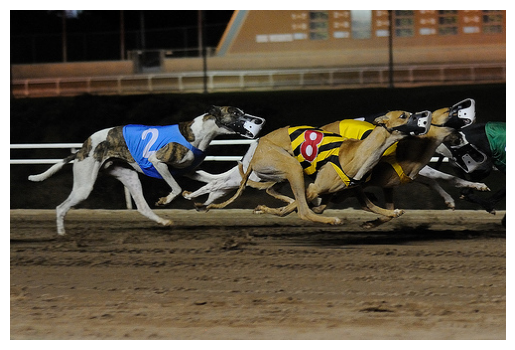

In [26]:
## loading the images
folder_path = '/kaggle/input/flickr8k/Images'
for file in os.listdir(folder_path):
  if(file.endswith(".jpg") or file.endswith(".png")):
    ##print(file)
    image_path=os.path.join(folder_path,file)
    image=Image.open(image_path)
image = Image.open(image_path)
# Display the image
plt.imshow(image)

plt.axis('off')
plt.show()

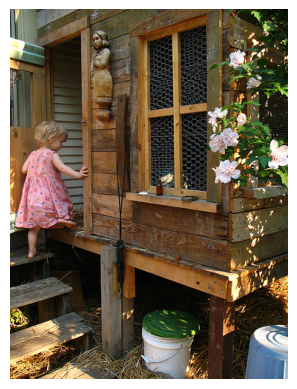

In [27]:
path_1='/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'
image_path=os.path.join(folder_path,file)
image=Image.open(image_path)
image = Image.open(path_1)
# Display the image
plt.imshow(image)

plt.axis('off')
plt.show()

In [28]:
def get_path(id):
  path='/kaggle/input/flickr8k/Images/'+id
  return path

In [29]:
df['Image_path']=df['Image ID'].apply(get_path)

In [30]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

In [31]:
list_paths=[]
for paths in df['Image_path']:
    if paths not in list_paths:
        list_paths.append(paths)

In [32]:
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 4s 0us/step


In [33]:
## For experimentation, freeze the layers of the pretrained Vision transformer
for layer in model.layers:
  layer.trainable = False
output_layer=model.layers[-2].output
intermediate_model = tf.keras.Model(inputs=model.input, outputs=output_layer)
intermediate_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
df

,Image ID,Caption,pre-processed captions,Image_path
1,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<start> a child in a pink dress is climbing up...,/kaggle/input/flickr8k/Images/1000268201_693b0...
2,1000268201_693b08cb0e.jpg,A girl going into a wooden building .\n,<start> a girl going into a wooden building \...,/kaggle/input/flickr8k/Images/1000268201_693b0...
3,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse...,<start> a little girl climbing into a wooden p...,/kaggle/input/flickr8k/Images/1000268201_693b0...
4,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,<start> a little girl climbing the stairs to h...,/kaggle/input/flickr8k/Images/1000268201_693b0...
5,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,<start> a little girl in a pink dress going in...,/kaggle/input/flickr8k/Images/1000268201_693b0...
...,...,...,...,...
40451,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face\n,<start> a man in a pink shirt climbs a rock fa...,/kaggle/input/flickr8k/Images/997722733_0cb543...
40452,997722733_0cb5439472.jpg,A man is rock climbing high in the air .\n,<start> a man is rock climbing high in the air...,/kaggle/input/flickr8k/Images/997722733_0cb543...
40453,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...,<start> a person in a red shirt climbing up a ...,/kaggle/input/flickr8k/Images/997722733_0cb543...
40454,997722733_0cb5439472.jpg,A rock climber in a red shirt .\n,<start> a rock climber in a red shirt \n <end>,/kaggle/input/flickr8k/Images/997722733_0cb543...


In [35]:
from tensorflow.keras import mixed_precision

# Enable mixed precision policy
mixed_precision.set_global_policy('mixed_float16')

In [36]:
# # extract features from image
# # commented because features extracted once
# features = {}
# directory = os.path.join('/kaggle/input/flickr8k', 'Images')

# for img_name in tqdm(os.listdir(directory)):
#     # load the image from file
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape data for model
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for vgg
#     image = preprocess_input(image)
#     # extract features
#     feature = model.predict(image, verbose=0)
#     # get image ID
#     image_id = img_name.split('.')[0]
#     # store feature
#     features[image_id] = feature

In [37]:
# # store features in pickle
# import pickle
# pickle.dump(features, open(os.path.join('/kaggle/working', 'features.pkl'), 'wb'))

In [38]:
# load features from pickle
import pickle
with open(os.path.join('/kaggle/working', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [39]:
# load features from pickle
# import os
# import pickle
# with open('/content/gdrive/MyDrive/Image_captioning/features.pkl', 'rb') as f:
#     features = pickle.load(f)

In [40]:
print(features['997722733_0cb5439472.jpg'])

[[0.        0.        0.9586396 ... 0.        0.        0.       ]]


In [41]:
# import pickle
# directory = '/tmp'
# if not os.path.exists(directory):
#     os.makedirs(directory)

# # Path to save the pickle file
# pickle_path = os.path.join(directory, 'features.pkl')

# # Dump data to the pickle file
# pickle.dump(features, open(pickle_path, 'wb'))

In [42]:
# from google.colab import files
# file_path = '/tmp/features.pkl'
# files.download(file_path)

In [43]:
## create a mapping of captions
caption_mapping={}
unique_image_ids=df['Image ID'].unique()
ind=0
for image_id in unique_image_ids:
  caption_list=[]
  for i in range(5):
    caption_list.append(df['pre-processed captions'].iloc[ind])
    ind+=1
  caption_mapping[image_id]=caption_list

In [76]:
from sklearn.model_selection import train_test_split

# Assuming you have your data and labels stored in 'data' and 'labels' variables, respectively
train_keys, test_keys = train_test_split(unique_image_ids, test_size=0.2, random_state=4)

In [77]:
len(train_keys)

6472

In [46]:
import tensorflow_addons as tfa
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense,Flatten,Bidirectional,LSTM
from tensorflow.keras.layers import Embedding,add,Dropout

In [78]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
dropout_layer1 = Dropout(0.4)(inputs1)
feature_layer1 = Dense(256, activation='relu')(dropout_layer1)
# sequence feature layers
inputs2 = Input(shape=(50,))
sequence_layer1 = Embedding(vocab_length, 256, mask_zero=True)(inputs2)
dropout_layer2 = Dropout(0.4)(sequence_layer1)
lstm_layer1 = LSTM(256,return_sequences=True)(dropout_layer2)
lstm_layer2 = LSTM(256)(lstm_layer1)
decoder_layer1=add([feature_layer1,lstm_layer2])
decoder_layer2 = Dense(256, activation='relu')(decoder_layer1)
output_layer = Dense(vocab_length, activation='softmax')(decoder_layer2)

In [79]:
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,AdamW
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import plot_model

In [80]:
decoder_model=Model(inputs=[inputs1,inputs2],outputs=output_layer)
decoder_model.compile(optimizer='adam',loss='categorical_crossentropy')

In [52]:
decoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 256)      2161152     ['input_7[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dropout_5 (Dropout)            (None, 50, 256)      0           ['embedding_2[0][0]']            
                                                                                            

In [81]:
# for image_id in train_keys:
#     if(image_id=='a'):
#         print("YES")
#     else:
#         print("NO")

In [82]:
# for image_id in train_keys:
#     for caption in caption_mapping[image_id]:
#         print(caption)

In [83]:
unique_image_ids[1]

'1001773457_577c3a7d70.jpg'

In [84]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [85]:
## dataloader for avoiding crashing
def dataloader(keys_list,features,caption_mapping,tokenizer,max_length,vocab_size,batch_size):
  n_images=0
  input_seq1,input_seq2,output_seq=list(),list(),list()
  for image_id in keys_list:
    n_images+=1
    for caption in caption_mapping[image_id]:
      # encode the sequence
      sequence = tokenizer.texts_to_sequences([caption])[0]
      for i in range(1,len(sequence)):
        input_sequence=sequence[:i]
        output_sequence=sequence[i]
        input_sequence = pad_sequences([input_sequence], maxlen=max_length)[0]
        # encode output sequence
        output_sequence = to_categorical([output_sequence], num_classes=vocab_size)[0]
        # store the sequences
        input_seq1.append(features[image_id][0])
        input_seq2.append(input_sequence)
        output_seq.append(output_sequence)
        if n_images == batch_size:
          input_seq1, input_seq2, output_seq = np.array(input_seq1), np.array(input_seq2), np.array(output_seq)
          yield [input_seq1, input_seq2], output_seq
          input_seq1,input_seq2,output_seq=list(),list(),list()
          n_images = 0

In [88]:
vocab_length

8442

In [89]:
# train the model
epochs = 12
batch_size = 32
steps = len(train_keys) // batch_size

for i in range(epochs):
    generator = dataloader(train_keys,features,caption_mapping,tokenizer,50,vocab_length,batch_size)
    # fit for one epoch
    decoder_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

202/202 [==============================] - 117s 578ms/step - loss: 2.2359


In [90]:
def generate_caption(model,tokenizer,max_length,image_feature):
  ## adding the start token as input
  input_text='start'
  for length in range(max_length):
    ## convert the text to sequence with tokenizer
    input_sequence=tokenizer.texts_to_sequences([input_text])[0]
    ## padd the sequnece to the requiered length
    input_sequence=pad_sequences([input_sequence],max_length)
    ## get the output from the model
    model_output=model.predict([image_feature,input_sequence],verbose=0)
    ## take max prob output
    model_output=np.argmax(model_output)
    ## convert this to word
    word_gen=index_to_word(model_output)
    if(word_gen==None):
      input_text+='end'
      break
    input_text+=' '+word_gen
    if(word_gen=='end'):
      break
  return input_text

5266
/kaggle/input/flickr8k/Images/3359636318_39267812a0.jpg 3359636318_39267812a0.jpg


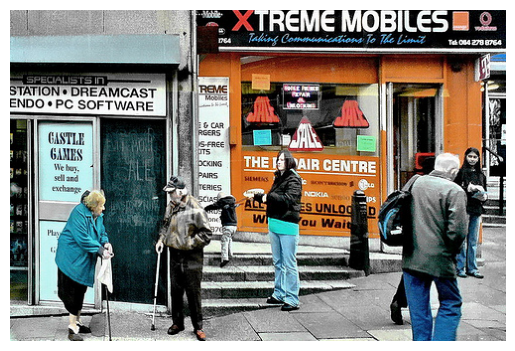

dataset captions are 

11
 a group of people are standing in front of some stores
 

9
 people stand on a sidewalk outside of retail stores
 

8
 people walking or talking on a city street
 

6
 several people in front of stores
 

17
 two people are talking outside of the video game shop next door to the mobile phone store
 

Generated caption is

[[0.        0.        0.        ... 0.        0.6671845 0.       ]]
start a man in a red jacket is trying to cross a street end


In [100]:
import random
no = random.randint(0,8090)
print(no)
Image_id=unique_image_ids[no]
image_path=list_paths[no]
print(image_path+" "+Image_id)
path_1=image_path
image_path=os.path.join(folder_path,file)
image=Image.open(image_path)
image = Image.open(path_1)
# Display the image
plt.imshow(image)

plt.axis('off')
plt.show()
print("dataset captions are \n")
for caption in caption_mapping[Image_id]:
    caption=caption.replace("<start>",'')
    caption=caption.replace("<end>",'')
    caption=caption.replace('  ','')
    print(len(caption.split()))
    print(caption+'\n')
print('Generated caption is\n')
image_feature=features[Image_id]
print(image_feature)
generated_cap=generate_caption(decoder_model,tokenizer,50,image_feature)
print(generated_cap)
generated_cap=generated_cap[0:19]

In [92]:
no = random.randint(0,8090)
Image_id=unique_image_ids[no]
image_feature=features[Image_id]
gen_caption=generate_caption(decoder_model,tokenizer,50,image_feature)
print(len(gen_caption))
gen_caption=gen_caption.split()
print(len(gen_caption))
gen_caption=gen_caption[0:19]
for words in gen_caption:
    print(words)

38
9
start
a
dog
is
running
on
a
street
end


In [63]:
def calculate_sentence_bleu1(reference, candidate):
    # Convert reference and candidate sentences to lists of tokens
    reference = [reference.split()]
    candidate = candidate.split()
    # Calculate BLEU score with default parameters (4-gram precision, no smoothing)
    bleu_score1 = sentence_bleu(reference, candidate,weights=(1.0,0,0,0))

    return bleu_score1

In [105]:
def calculate_sentence_bleu2(reference, candidate):
    # Convert reference and candidate sentences to lists of tokens
    reference = [reference.split()]
    candidate = candidate.split()
    smooth_fn = SmoothingFunction().method3
    # Calculate BLEU score with default parameters (4-gram precision, no smoothing)
    bleu_score2 = sentence_bleu(reference, candidate,weights=(0.5,0.5,0,0))

    return bleu_score2

In [65]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smooth_fn = SmoothingFunction().method3

l1=[]
l2=[]
fn=SmoothingFunction
s1="two black dogs are tugging on a red toy that is in a brown dogs mouth"
# s1=s1.split()
# l1.append(s1)
s2="a black dog is tugging on a red toy in a grassy field"
# s2=s2.split()
# l2.append(s2)
score = calculate_sentence_bleu1(s1,s2)
print(score)

0.5496387631047355


In [106]:
##testing on sentences 
# no = random.randint(0,8090)
import warnings
warnings.filterwarnings("ignore")
scoreovr=0
keys_new=test_keys[:600]
for Image_id in keys_new: 
#     Image_id=unique_image_ids[no]
    image_feature=features[Image_id]
    gen_caption=generate_caption(decoder_model,tokenizer,50,image_feature)
    gen_caption=gen_caption.replace("start",'')
    gen_caption=gen_caption.replace("end",'')
    gen_caption=gen_caption.replace('  ','')
    actual_caption=caption_mapping[Image_id]
    maxscore=0
    for caption in actual_caption:
        caption=caption.replace("<start>",'')
        caption=caption.replace("<end>",'')
        caption=caption.replace('  ','')
        score=calculate_sentence_bleu2(gen_caption,caption)
#         print(score)
        if(score>maxscore):
            maxscore=score
#     print(maxscore)
    scoreovr+=maxscore
    #print(no)
print("Bleu-2 score is "+str(scoreovr/600))
# print(gen_caption)

Bleu-2 score is 0.4479504573901499


In [67]:
##testing on sentences 
# no = random.randint(0,8090)
scoreovr=0
keys_new=test_keys[:405]
for Image_id in keys_new: 
#     Image_id=unique_image_ids[no]
    image_feature=features[Image_id]
    gen_caption=generate_caption(decoder_model,tokenizer,50,image_feature)
    gen_caption=gen_caption.replace("start",'')
    gen_caption=gen_caption.replace("end",'')
    gen_caption=gen_caption.replace('  ','')
    actual_caption=caption_mapping[Image_id]
    maxscore=0
    for caption in actual_caption:
        caption=caption.replace("<start>",'')
        caption=caption.replace("<end>",'')
        caption=caption.replace('  ','')
        score=calculate_sentence_bleu2(gen_caption,caption)
#         print(score)
        if(score>maxscore):
            maxscore=score
#     print(maxscore)
    scoreovr+=maxscore
    #print(no)
print("Bleu-2 score is "+str(scoreovr/405))
# print(gen_caption)

Bleu-2 score is 0.24600881981930875


In [68]:
decoder_model.save("/kaggle/working/lstm_model.h5")